## Polars home page (https://pola.rs/) 
## The User Guide home page (https://docs.pola.rs/)

#Installation

pip install polars

In [10]:
from hh_transmission_model import run_SEIR_model_pl, plot_SEIR_pl, Params
from pandas_transmission_model import run_SEIR_model_pd, plot_SEIR_pd
import time
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Parameters
params = Params(
    no_runs=10,
    pop_size=5000,
    inf_duration=10, 
    exposed_duration=4,
    random_seed=5,
    transmission_rate=0.02,
    time_horizon=50,
    time_step=0.5,
    record_transmission=True,
    record_all_new_cases=True
)

In [22]:
pop_sizes = [500, 5000, 50000, 500000]
polars_exec_times = []
pandas_exec_time = []
for pop_size in pop_sizes:
    setattr(params, 'pop_size', pop_size)  
    # get the start time
    st = time.time()
    results_pl = run_SEIR_model_pl(params)
    # get the end time
    et = time.time()
    # get the execution time
    elapsed_time_pl = et - st
    polars_exec_times.append(elapsed_time_pl)
    print('Pop size', pop_size,' - Polars execution time:', round(elapsed_time_pl, 1), 'seconds')   

    # get the start time
    st = time.time()
    results_pd = run_SEIR_model_pd(params)
    # get the end time
    et = time.time()
    # get the execution time
    elapsed_time_pd = et - st
    pandas_exec_time.append(elapsed_time_pd)
    print('Pop size', pop_size,' - Pandas execution time:', round(elapsed_time_pd, 1), 'seconds')   

"""
Pop size 500  - Polars execution time: 1.5 seconds
Pop size 500  - Pandas execution time: 1.4 seconds
Pop size 5000  - Polars execution time: 2.0 seconds
Pop size 5000  - Pandas execution time: 3.8 seconds
Pop size 50000  - Polars execution time: 4.4 seconds
Pop size 50000  - Pandas execution time: 27.8 seconds
Pop size 500000  - Polars execution time: 24.3 seconds
Pop size 500000  - Pandas execution time: 273.0 seconds
"""    

Pop size 500  - Polars execution time: 1.5 seconds
Pop size 500  - Pandas execution time: 1.4 seconds
Pop size 5000  - Polars execution time: 1.9 seconds
Pop size 5000  - Pandas execution time: 3.9 seconds
Pop size 50000  - Polars execution time: 4.4 seconds
Pop size 50000  - Pandas execution time: 27.5 seconds


/Users/ntelliogluce/python_envs/pneu_env/lib/python3.9/site-packages/numpy/ctypeslib.py:524: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return asarray(obj)


Pop size 500000  - Polars execution time: 24.4 seconds
Pop size 500000  - Pandas execution time: 271.0 seconds


'\nPop size 500  - Polars execution time: 1.5 seconds\nPop size 500  - Pandas execution time: 1.4 seconds\nPop size 5000  - Polars execution time: 2.0 seconds\nPop size 5000  - Pandas execution time: 3.8 seconds\nPop size 50000  - Polars execution time: 4.4 seconds\nPop size 50000  - Pandas execution time: 27.8 seconds\nPop size 500000  - Polars execution time: 24.3 seconds\nPop size 500000  - Pandas execution time: 273.0 seconds\n'

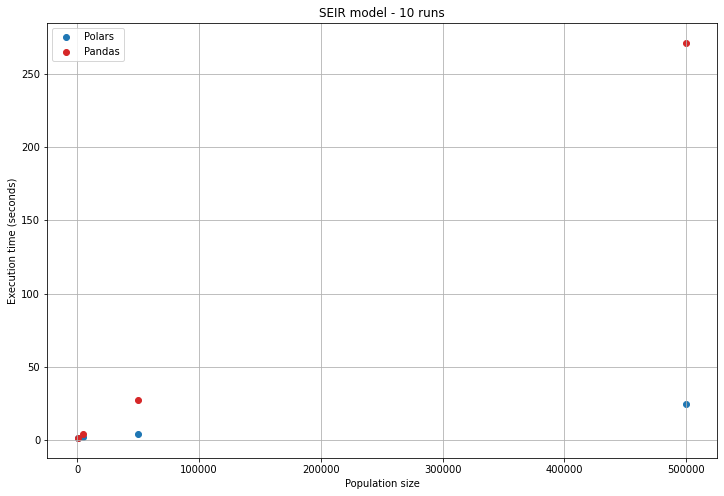

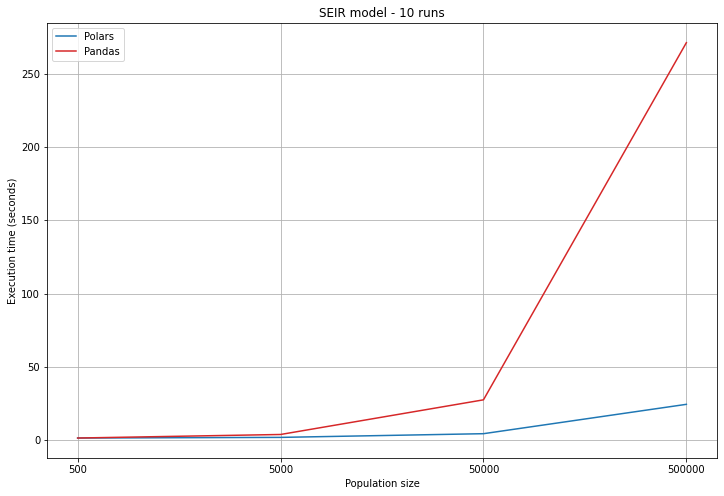

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.scatter(pop_sizes[:], polars_exec_times[:], color="tab:blue", label="Polars")
plt.scatter(pop_sizes[:], pandas_exec_time[:], color="tab:red", label="Pandas")

plt.xlabel("Population size")
plt.ylabel("Execution time (seconds)")
plt.title("SEIR model - %s runs"%params.no_runs)
plt.grid()

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

fig, ax = plt.subplots(figsize=(12, 8))

plt.plot([str(size) for size in pop_sizes], polars_exec_times, color="tab:blue", label="Polars")
plt.plot([str(size) for size in pop_sizes], pandas_exec_time, color="tab:red", label="Pandas")

plt.xlabel("Population size")
plt.ylabel("Execution time (seconds)")
plt.title("SEIR model - %s runs"%params.no_runs)
plt.grid()

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()
fig.savefig('exec_time.tiff', bbox_inches="tight", dpi=300)

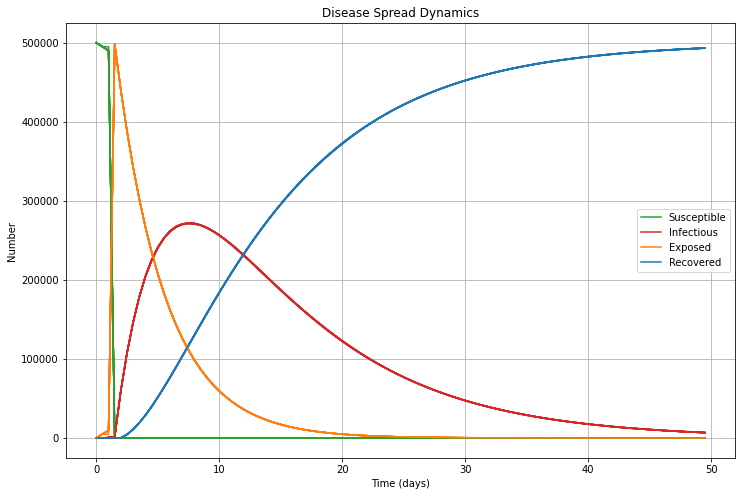

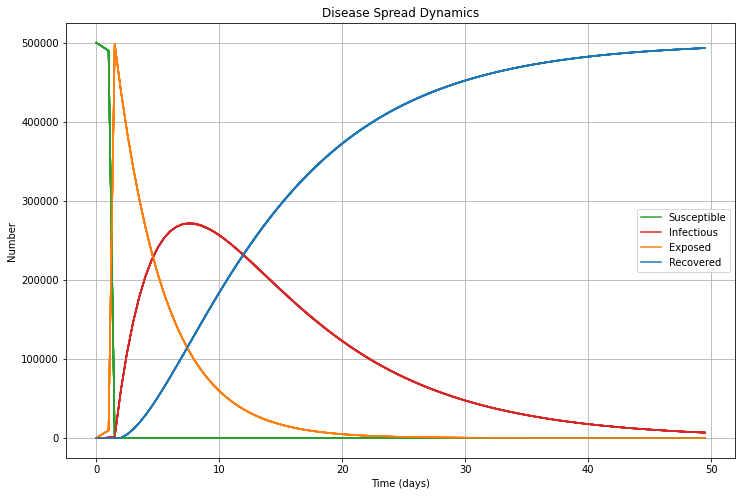

In [31]:
#plot results
plot_SEIR_pl(results_pl["all_transmission"])
plot_SEIR_pd(results_pd["all_transmission"])

## Data structures in Polars

In [36]:
# Create a dataframe

#empty dataframe
population = pl.DataFrame()


pop_size = 2

#Create a dataframe via dictionary
population = pl.DataFrame(
                        {
                        "id": range(pop_size),
                        "state": ["Susceptible"] * pop_size,
                        }
                        )
print(population)

#Create a dataframe via list of polars Series
population2 = [
                pl.Series("id", range(pop_size), dtype=pl.Int64),
                pl.Series("state",  ["Susceptible"] * pop_size),  
            ]
population2 = pl.DataFrame(population2)
print(population2)


shape: (2, 2)
┌─────┬─────────────┐
│ id  ┆ state       │
│ --- ┆ ---         │
│ i64 ┆ str         │
╞═════╪═════════════╡
│ 0   ┆ Susceptible │
│ 1   ┆ Susceptible │
└─────┴─────────────┘
shape: (2, 2)
┌─────┬─────────────┐
│ id  ┆ state       │
│ --- ┆ ---         │
│ i64 ┆ str         │
╞═════╪═════════════╡
│ 0   ┆ Susceptible │
│ 1   ┆ Susceptible │
└─────┴─────────────┘


In [33]:
#add rows
#https://stackoverflow.com/questions/71654966/how-can-i-append-or-concatenate-two-dataframes-in-python-polars
pop_size = 2
population = pl.DataFrame(
                        {
                        "id": range(pop_size),
                        "state": ["Susceptible"] * pop_size,
                        }
                        )

population2 = pl.DataFrame([
    pl.Series("id", [3], dtype=pl.Int64),
    pl.Series("state",  ["Infectious"]),
])
print(population2)

# new memory slab
new_population = pl.concat([population, population2], rechunk=True)

# append free (no memory copy)
new_population2 = population.vstack(population2)

# try to append in place
population.extend(population2)
print(population, new_population, new_population2)


shape: (1, 2)
┌─────┬────────────┐
│ id  ┆ state      │
│ --- ┆ ---        │
│ i64 ┆ str        │
╞═════╪════════════╡
│ 3   ┆ Infectious │
└─────┴────────────┘
shape: (3, 2)
┌─────┬─────────────┐
│ id  ┆ state       │
│ --- ┆ ---         │
│ i64 ┆ str         │
╞═════╪═════════════╡
│ 0   ┆ Susceptible │
│ 1   ┆ Susceptible │
│ 3   ┆ Infectious  │
└─────┴─────────────┘ shape: (3, 2)
┌─────┬─────────────┐
│ id  ┆ state       │
│ --- ┆ ---         │
│ i64 ┆ str         │
╞═════╪═════════════╡
│ 0   ┆ Susceptible │
│ 1   ┆ Susceptible │
│ 3   ┆ Infectious  │
└─────┴─────────────┘ shape: (3, 2)
┌─────┬─────────────┐
│ id  ┆ state       │
│ --- ┆ ---         │
│ i64 ┆ str         │
╞═════╪═════════════╡
│ 0   ┆ Susceptible │
│ 1   ┆ Susceptible │
│ 3   ┆ Infectious  │
└─────┴─────────────┘


### Polars: with_columns()

In [3]:
#add a new column
# Introduce pl.lit()

#
#rename columns
#alias and rename()
#sort

#height

# update pop dynamics
"""
self.P.I = (
               self.P.I
               .with_columns(
                   
                  ( pl.col('age').add((pl.col('age_days') + period) // 364).alias('age')),
                   
                   ((pl.col('age_days') + period) % 364).alias('age_days'),
                   
                  ((pl.col('age') + (pl.col('age_days') + period)// 364) // 5)
                  .alias('age_group'),
                    
                  #(will_live(self.P.I["age"], self.death_rates[t], self.rng)),
                  
                  
                  ((pl.col('random') < death_rates.list.take(self.P.I["age"])[0]).alias("alive")),
                  
                  (pl.lit(self.rng.rand(self.P.I.height))).alias("random"),
                  
                   ).filter(pl.col("alive")).drop("alive")
               )

"""

# assign an exposed from column
"""
P.I = (
                    P.I.with_columns(
                    exposed_strains = self.strain_distribution["strain"][
                        rng.choice(len(self.strain_distribution["strain"]),
                                    p = self.strain_distribution["fraction"],
                                              size = len(P.I))]
             )).sort("random", "no_of_strains", "age_group", descending=False)
"""

#vaccine a target group


#calculate age-group specific foi and infect indiivduals and update the individuals


#identify individuals that are going to be infected by exposed strains
"""P.I = (P.I.with_columns(
                   (  pl.col("random") <= (\
                (1 * (pl.col("no_of_strains") < self.max_no_coinfections)) *\
                    (prob_infection.list.take(P.I["age_group"])[0] *\
                     (1 -  (self.reduction_in_susceptibility) * \
                          (pl.col("no_of_strains"))) * \
                            (1 - \
            pl.col("exposed_strains").is_in(pl.col("strain_list")))     
                                 )
                   )).alias("will_infected"),
               
                   (pl.lit(rng.rand(P.I.height)).alias("random")),
                   ))
"""


#recover individuals with multiple infections
"""
recovered = (
            P.I.filter((pl.col("endTimes").list.eval(pl.element()
                            .filter(pl.element() <= day))).list.lengths() > 0)
            .select(["id", "strain_list", "endTimes", "no_of_strains"])
        )
        
       
        
recovered = (
            recovered.with_columns(
            (pl.col("endTimes").list.eval(pl.element()
                     .filter(pl.element() > day))),
            (pl.col("strain_list").list.eval(pl.element()).list
             .take(pl.col("endTimes").list
        .eval((pl.element() > day).arg_true()))),
           ).with_columns(
               (((pl.col("strain_list").list.lengths()))
                 .cast(pl.Int32).alias("no_of_strains"))))
               #.filter(pl.col("endTimesIndexes").list.lengths() > 0)
            
P.I = P.I.update(recovered, on="id", how="left")
"""



#check the antibody levels of individuals given a vaccine list and antibody log
"""


"""

'P.I = (P.I.with_columns(\n                   (  pl.col("random") <= (                (1 * (pl.col("no_of_strains") < self.max_no_coinfections)) *                    (prob_infection.list.take(P.I["age_group"])[0] *                     (1 -  (self.reduction_in_susceptibility) *                           (pl.col("no_of_strains"))) *                             (1 -             pl.col("exposed_strains").is_in(pl.col("strain_list")))     \n                                 )\n                   )).alias("will_infected"),\n               \n                   (pl.lit(rng.rand(P.I.height)).alias("random")),\n                   ))\n'

In [ ]:
### Polars: filter() & select()

### Polars: Update()

### Polars: Join()

### Polars: struct columns

In [ ]:
#unnest, field

### Join()

In [ ]:
### take()

"""
late_vacc = (late_vacc.with_columns(
                        (pl.lit(rng.rand(late_vacc.height))
                             .alias("random")),
                        
                        pl.struct(
                        ((pl.col("vaccines").struct.field("no_of_doses") + 1)
                        .alias("no_of_doses")),
                            (-1 * (
                                day + \
                                    current_daily_schedules.take(
                        late_vacc["vaccines"].struct.field("no_of_doses") + 1)
                              - current_daily_schedules.take(
                            late_vacc["vaccines"].struct.field("no_of_doses"))
                               )).cast(pl.Int64).alias("on_time"),
                            #(pl.col("vaccines").struct.field("on_time")),
                            (pl.lit(vaccine)).alias("vaccine_type"),
                             pl.lit(day).alias("final_vaccine_time"),
                             ).alias("vaccines")
                        
                        ))
"""

## Introduction to Lazy DataFrame
